# LSTM Architectures: a case study for ACWI prediction

## Feature Engineering


In [ ]:
## Install Requirements
%pip install -r ../requirements.txt

#### Import Library

In [1]:
## Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

## Data Analysis
from scipy.stats import norm 

## Feature Expansion
import pandas_ta as ta # Extends the capabilities of Pandas for financial technical analysis

## Train Test Split
from sklearn.model_selection import train_test_split

## Feature Transformation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Feature Selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import shap

## Import Functions
from aux_functions import *

### Load Data

In [1]:
## Load Clean data
df_raw = pd.read_csv('../../Input/input.csv', index_col=0)

## Set a seed
set_seeds(seed=10)

## 2 - EDA 

In [ ]:
## Compute Summary Statistics
summary_statistics = df_raw.describe().T

## Add a column for Missing 
summary_statistics['missing_data'] = df_raw.isna().sum()

# Display the resulting DataFrame
print(summary_statistics)

del summary_statistics

## 3 - Feature Expansion

In [36]:
## Copy
df_etf =  df_raw.drop( columns=['open', 'high', 'low', 'close', 'volume'] ).copy()

## Feature Expansion 
X = df_raw[['open', 'high', 'low', 'close', 'volume']].copy()

##  OC, HL
X['OC'] = X['open']/ X['close']
X['HL'] = X['high']/ X['low']

### Prepare Data for Pandas TA

## Convert the index to datetime format with a default time component (midnight)
X.index = pd.to_datetime(X.index).normalize()

## Apply the pandas_ta strategy
X.ta.strategy('all')

## Revert the index back to the original
X.index = df_raw.index

## Merge 
X = pd.merge(X, df_etf, left_index=True, right_index=True, how='inner')

## Del
del df_etf

### Correct errors after Pandas TA

## Drop undersired columns
X = X.drop(['open', 'high', 'low',
            'HILOl_13_21', 
            'HILOs_13_21', 
            'PSARl_0.02_0.2', 
            'PSARs_0.02_0.2', 
            'PSARaf_0.02_0.2', 
            'QQEl_14_5_4.236', 
            'QQEs_14_5_4.236', 
            'SUPERTl_7_3.0', 
            'SUPERTs_7_3.0'], axis=1)

## Maybe should do a forward fill here!
## Remove first rows (missed because you used grau degree of freadom to create new features )
X = X.dropna()

## Backfill
X = X.bfill(axis=1)

## Lose the last data to take care of 1day ahead prediction
X = X[:-1] 

## ACWI + Ret 
acwi = X['close']
ret = np.log(X['close']).diff()

## Drop Close
X = X.drop(['close'], axis=1)

0it [00:00, ?it/s]

131it [00:03, 35.96it/s]


In [ ]:
## Check 1: Check for Missing Values
print("Missing Values Check:")
print(X.isnull().sum())

## Check 2: Inspect Data Types
print("\nData Types Check:")
print(X.dtypes)

## Check 3: Inspect Data Types
print("\nInfinite Values Check:")
print(np.isinf(X).sum())

# Check 4: Inspect the First Few Rows
print("\nFirst Few Rows:")
print(X.head())

## 4 Target Threshold

CDF Position
0.5073872830694327


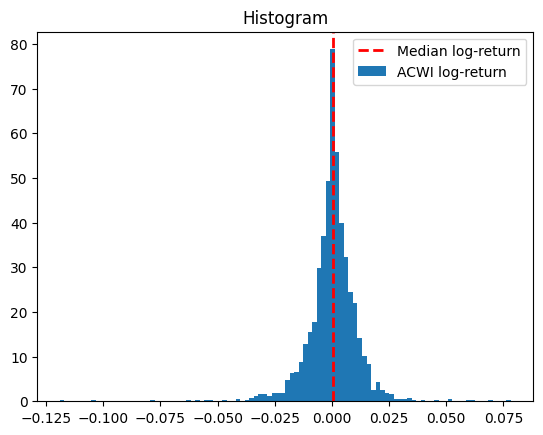

In [37]:
# Calculate the median of the ACWI log returns
median_log_return = ret.median()

# Calculate the CDF value for the median
median_position = norm.cdf(median_log_return, ret.mean(), ret.std())

print('CDF Position')
print(median_position)

# Plot histogram of TLT return
plt.hist(ret , bins=100, density=True, label='ACWI log-return', alpha=1)
# Set title
plt.title('Histogram')

# Add a vertical line at the median
plt.axvline(median_log_return, color='red', linestyle='dashed', linewidth=2, label='Median log-return')
# Set legends
plt.legend()

## Save 
plt.savefig('../Plot/Feature Engineering/histogram.pdf', format='pdf', bbox_inches='tight')

## Show 
plt.show()

In [38]:
## Class Imbalance if we set threshold to median
y = np.where(ret.shift(-1) > median_log_return, 1, 0)
print( pd.Series(y).value_counts() )

# Converts all dtype to objects
y = y.astype(int) 

## Del
del median_log_return, median_position, ret

0    992
1    991
dtype: int64


## 5 Feature Transformation

In [39]:
## Split data into training and testing
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle=False)  

# Train and test data size
print(f"Train and Test Size {len(X_train_1)}, {len(X_test_1)}")

Train and Test Size 1586, 397


#### Outlier Analysis

In [40]:
## Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform( X_train_1.iloc[:, :-1] )

## Convert to PD
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns[:-1])

## Define a threshold for outliers 
outlier_threshold = 2

## Calculate the percentage of outliers in a column
def calculate_outlier_percentage(column):
    return ((abs(column) > outlier_threshold).sum()) / len(column)

## Calculate the percentage of outliers for each feature
outlier_percentages = X_scaled_df.apply(calculate_outlier_percentage)

## Indicator, where 1 mean more than 5% are outliers 
outlier_index = (outlier_percentages > 0.05).astype(int)

# #Identify columns with an index of 1
columns_with_outliers = outlier_index[outlier_index == 1].index.tolist()

print("Columns with a substantial number of outliers:", columns_with_outliers)

del columns_with_outliers, outlier_percentages, outlier_threshold, X_scaled_df, X_scaled, scaler


Columns with a substantial number of outliers: ['OC', 'ADOSC_3_10', 'DMP_14', 'APO_12_26', 'CDL_DOJI_10_0.1', 'CDL_INSIDE', 'CFO_9', 'DPO_20', 'KURT_30', 'KVO_34_55_13', 'KVOs_34_55_13', 'MACDh_12_26_9', 'PSARr_0.02_0.2', 'PVO_12_26_9', 'PVOs_12_26_9', 'QS_10', 'SLOPE_1', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZPRO_20_2.0_20_2_1.5_1', 'THERMOl_20_2_0.5', 'FILL']


In [41]:
## Features to Scaler
col_scaler = ['OC', 'ADOSC_3_10', 'DMP_14', 'APO_12_26', 'CDL_DOJI_10_0.1', 'CDL_INSIDE', 'CFO_9', 'DPO_20', 'KURT_30', 'KVO_34_55_13', 'KVOs_34_55_13', 'MACDh_12_26_9', 
              'PSARr_0.02_0.2', 'PVO_12_26_9', 'PVOs_12_26_9', 'QS_10', 'SLOPE_1', 'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZPRO_20_2.0_20_2_1.5_1', 'THERMOl_20_2_0.5', 'FILL']

ind_scaler = [X_train_1.columns.get_loc(col) for col in col_scaler if col in X_train_1.columns]

## Features do Minmax 
ind_minmax = [i for i in range(X_train_1.shape[1]) if i not in [ *ind_scaler] ]

## ColumnTransformer with both StandardScaler and MinMaxScaler
ct = ColumnTransformer( transformers=[ ('scaler', StandardScaler(), [*ind_scaler] ),   ('minmax', MinMaxScaler(), ind_minmax) ])

## Scale Features
X_train_2 = ct.fit_transform(X_train_1)
X_test_2  = ct.transform(X_test_1)

## Feature name
feature_names = ( [X_train_1.columns[i] for i in ind_scaler] +  [X_train_1.columns[i] for i in ind_minmax] )

del ct, col_scaler, ind_scaler, ind_minmax

## 6 Feature Selection

### 6.1- Boruta Method 

In [42]:
## Random Forest Classifier 
forest = RandomForestClassifier(n_jobs=-1,random_state=10,  max_depth=4 )

## Train the model
forest.fit(X_train_2, y_train)

## Run Boruta 
feat_selector = BorutaPy( forest, random_state=10,  verbose=0, n_estimators='auto', max_iter= 200, perc=70, )                   
                        
## Find all relevant features
feat_selector.fit(X_train_2, y_train)

## Adjust the Support to include features with unthil a chosen threshold
feat_selector.support_ = [True if rank <= 11 else False for rank in feat_selector.ranking_]

## Feature Rank
feature_ranks = list(zip(feature_names, feat_selector.ranking_, feat_selector.support_))
feature_ranks = sorted(feature_ranks, key=lambda x: x[1])

## Print Number of Features and Rank
print(f'Number of features selected: {sum(rank <= 11 for rank in feat_selector.ranking_)}')
for feat in feature_ranks:
    print(f'Feature: {feat[0]:<30} Rank: {feat[1]:<8} Keep: {feat[2]}')
    
 ## Filter Boruta
feat_boruta = [feature_names[i] for i, is_selected in enumerate(feat_selector.support_) if is_selected]   

X_train_3 = pd.DataFrame( feat_selector.transform(X_train_2), columns= feat_boruta )
X_test_3  = pd.DataFrame( feat_selector.transform(X_test_2), columns= feat_boruta  )

## Save/Load Features 
#pd.DataFrame(X_test_3).to_csv('../Output/Variables/X_test_3.csv', index=False, header=True)
#pd.DataFrame(X_train_3).to_csv('../Output/Variables/X_train_3.csv', index=False, header=True)

del X_train_1, X_test_1, X_train_2, X_test_2, feature_ranks, feat_boruta, feature_names

BorutaPy(estimator=RandomForestClassifier(max_depth=4, n_estimators=212,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1F5B92A7E40),
         max_iter=200, n_estimators='auto', perc=70,
         random_state=RandomState(MT19937) at 0x1F5B92A7E40)

### 6.2- SHAP (SHapley Additive exPlanations) 

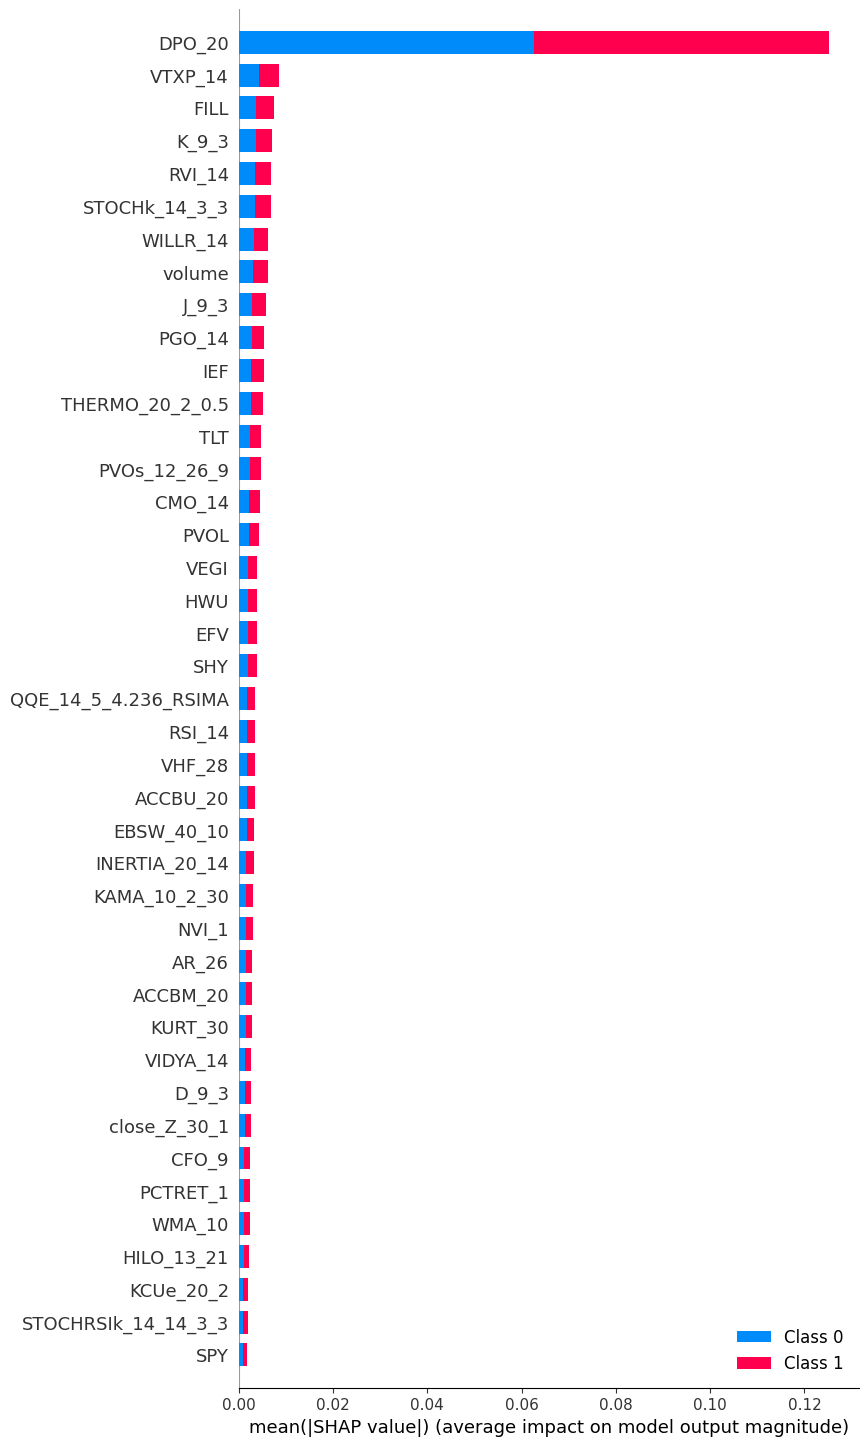

In [80]:
## Train Model with the new Feature Set
forest.fit(X_train_3, y_train)

## Initialize the SHAP explainer with the model and test data
explainer = shap.TreeExplainer(forest)

## Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train_3)

## Plot
shap.summary_plot(shap_values, X_train_3, plot_type="bar", max_display=41)  

del shap_values, explainer

## 6.3- Feature Importance

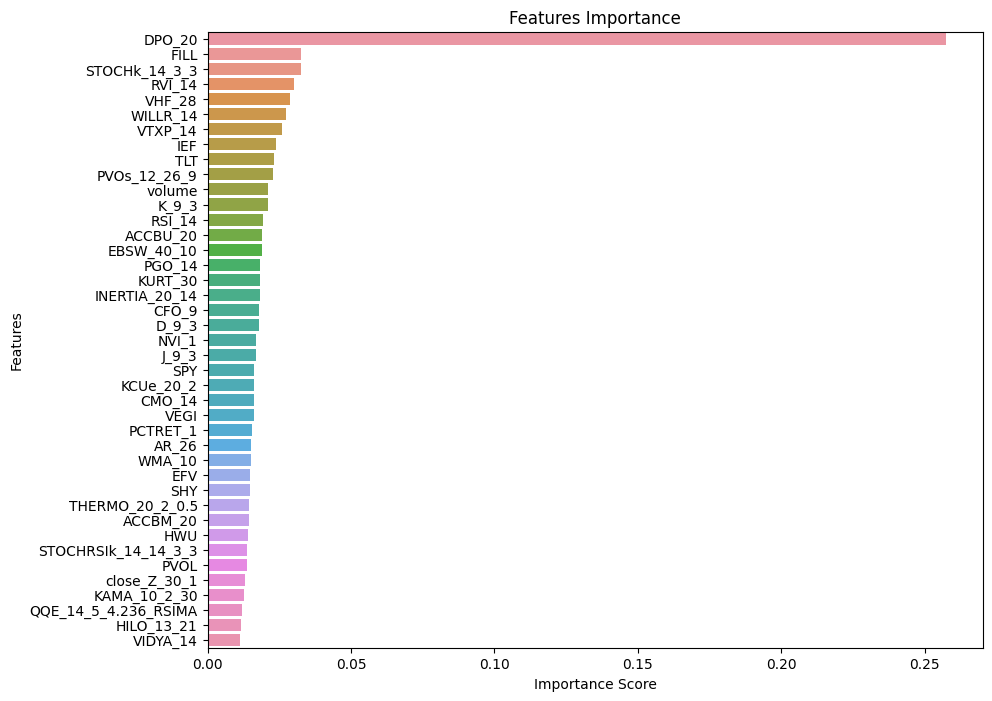

In [73]:
## Create Feature Importance
feature_imp = pd.DataFrame({'Importance Score': forest.feature_importances_,'Features': X_train_3.columns}).sort_values(by='Importance Score', ascending=False)

## Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x=feature_imp['Importance Score'], 
            y=feature_imp['Features'])

## Set title
ax.set_title('Features Importance')

## Save 
plt.savefig('../Plot/Feature Engineering/feat_importance.pdf', format='pdf', bbox_inches='tight')

## Display
plt.show()

del fig, ax, feature_imp

### 6.4- Correlation Matrix

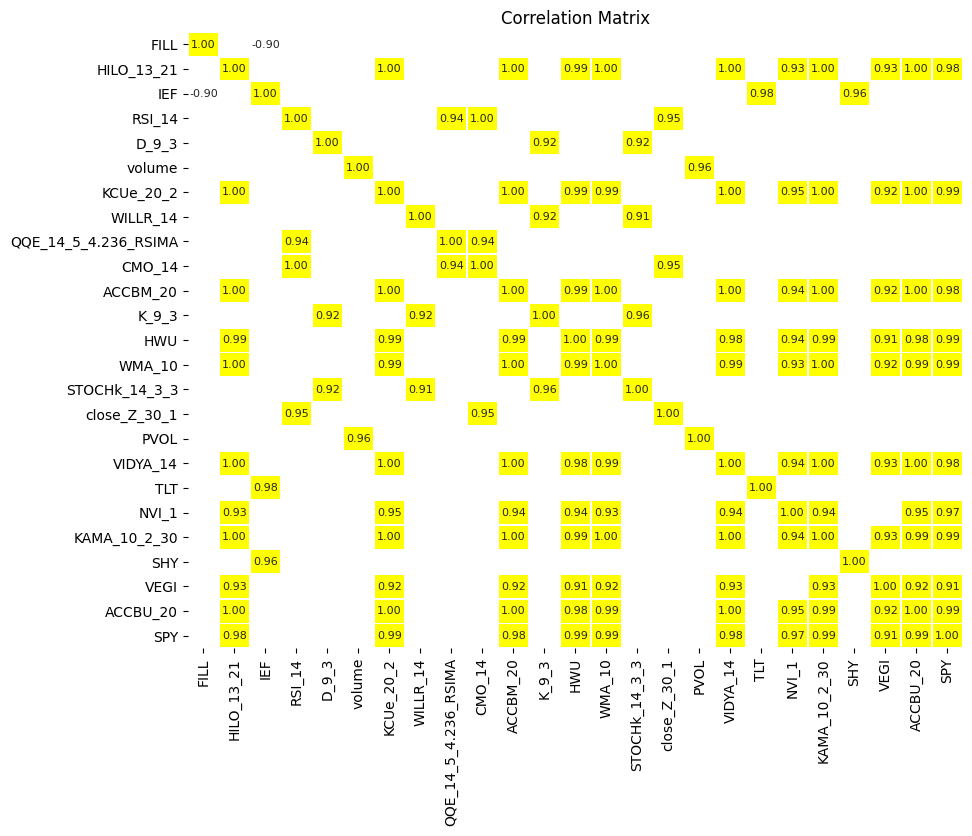

In [75]:
## Correlation Threshold
cor_threshold = 0.9

## Identify variables that have a correlation above the threshold
highly_correlated_vars = set()
corr_matrix = X_train_3.corr()
num_features = corr_matrix.shape[0]

for i in range(num_features):
    for j in range(i + 1, num_features):
        if abs(corr_matrix.iloc[i, j]) >= cor_threshold:
            highly_correlated_vars.add(corr_matrix.columns[i])
            highly_correlated_vars.add(corr_matrix.columns[j])

## Create X_train_cor with only the variables that meet the correlation threshold
X_train_cor = X_train_3[list(highly_correlated_vars)]

## Create a mask for correlations above the threshold
mask = np.abs(X_train_cor.corr()) <= cor_threshold

## Create a custom colormap: dark red for high correlation, white for others
cmap = sns.color_palette(["white", "yellow"], as_cmap=True)

## Plot the correlation matrix with dark red for above threshold and white for below threshold, no color bar
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_cor.corr(), annot=True, annot_kws={"size": 8}, fmt=".2f", linewidth=0.5, cmap=cmap, cbar=False, mask=mask)
plt.title('Correlation Matrix')

## Save 
plt.savefig('../Plot/Feature Engineering/correlation.pdf', format='pdf', bbox_inches='tight')

## Display
plt.show()

del cmap, mask, highly_correlated_vars, corr_matrix, num_features, i, j


## 7 - Final Feature Set

In [99]:
## Variables that should be drop after the correlation analysis
final_drop = [ 'ACCBM_20', 'ACCBU_20', 'close_Z_30_1', 'CMO_14', 'D_9_3', 'HILO_13_21', 'KAMA_10_2_30', 'KCUe_20_2', 'NVI_1', 'QQE_14_5_4.236_RSIMA']

## Filter Selected Variables
X_train =  X_train_3.drop( columns= final_drop ).copy()
X_test  =  X_test_3.drop(  columns= final_drop ).copy()

## Concatenate
X_final = pd.concat([X_train, X_test], axis=0, ignore_index=True)
df = pd.concat([ X_final, pd.Series(y, name='Target')],  axis=1)
df.index = X.index

del final_drop

#### Save

In [101]:
## Data + ACWI Close Price
df.to_csv('../../Input/feat_final.csv', index=True)
acwi.to_csv('../../Input/acwi.csv', index=True)

## Save Lookback
seqlen = 21 # 63
seqlen = pd.DataFrame([seqlen])
seqlen.to_csv('../Output/Variables/seqlen.csv', index=False, header=False)

## Save feature numbers
numfeat = pd.DataFrame([ X_final.shape[1] ])
numfeat.to_csv('../Output/Variables/numfeat.csv', index=False, header=False)